In [48]:
import pandas as pd
import numpy as np
import sklearn as sk
import csv
from sklearn.linear_model import LinearRegression
#linreg gives straight line
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
#doesnt work idk
from sklearn.ensemble import RandomForestClassifier
#doesnt work
from sklearn.ensemble import RandomForestRegressor
#gives me 1 entire value
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
#gives me 1 value
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import MultiTaskLasso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
import time
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from geopy import distance
import preprocess as pre

In [49]:
train = pd.read_csv("ais_train.csv", sep='|')
test = pd.read_csv("ais_test.csv")
train['time'] = pd.to_datetime(train['time'])
test['time'] = pd.to_datetime(test['time'])

train.tail()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
1522060,2024-05-07 23:59:07,359.1,13.4,0,1,0,05-08 05:00,52.19131,-5.82223,clh6aqawa0002gh0zypfa5dut,634c4de270937fc01c3a7417
1522061,2024-05-07 23:59:08,12.3,17.1,0,13,0,05-10 03:00,38.96142,-12.00502,61e9f3aeb937134a3c4bfe43,634c4de270937fc01c3a76a1
1522062,2024-05-07 23:59:08,269.8,14.9,-1,270,0,05-15 23:00,49.71372,-5.22042,61e9f43db937134a3c4c0169,634c4de270937fc01c3a787b
1522063,2024-05-07 23:59:08,8.0,18.7,0,6,0,05-08 12:45,38.27895,10.78280,61e9f469b937134a3c4c029b,61d3781293c6feb83e5eb73b
1522064,2024-05-07 23:59:08,336.0,14.3,5,337,0,05-07 23:00,38.98635,-75.13275,62080cff66fc0a8e43c6123a,61d38528b7b7526e1adf3e6f


In [3]:
start = time.time()
#pre.ais_trainCleanup("~/proj2/ML/Henrik/ais_train.csv","ais_clean.csv")
print(time.time()-start)

4.267692565917969e-05


In [50]:
cleandata = pd.read_csv("ais_clean.csv",sep="|")
cleandata.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,drift,at_port,time_at_sea,dist_s_l,tot_dist,time_s_l,speed
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,2024-01-09 23:00:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,196.0,False,0 days 00:00:00,0.0,0.0,0,0.0
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,2024-12-29 20:00:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,-237.4,False,0 days 00:00:00,0.0,0.0,0,0.0
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,2024-01-02 09:00:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,-1.0,False,0 days 00:00:00,0.0,0.0,0,0.0
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,2024-12-31 20:00:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,-45.6,False,0 days 00:00:00,0.0,0.0,0,0.0
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,2024-01-25 12:00:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,-1.0,False,0 days 00:00:00,0.0,0.0,0,0.0


In [51]:
#endrer tid og 1hoter vessel
warnings.filterwarnings('ignore')

def preprocess(df):
    data = df.copy()
    time3 = []
    for i in data['time']:
        time3.append(int(i.timestamp()-1704067200))
    data['time'] = np.array(time3, dtype = 'float32')
    data = pd.get_dummies(data, columns=['vesselId'], drop_first=True)
    return(data)

test2 = test.copy()
df2 = train.copy()
#ignorerer alle de ubrukelige verdiene 8)
goaldata = df2.drop(columns=['cog','sog','rot','heading','navstat','etaRaw','portId','time','vesselId'])
heading2 = df2.drop(columns=['cog','heading','rot','navstat','etaRaw','portId','time','vesselId','latitude','longitude'])
df2 = preprocess(df2)
trainingdatahead = df2.drop(columns=['cog','rot','sog','heading','navstat','etaRaw','heading','latitude','longitude','portId'])
trainingdata = df2.drop(columns=['cog','heading','rot','navstat','etaRaw','latitude','longitude','portId'])
test2 = preprocess(test2)

#legger til de vesselIdene som ikke er i treningsdataen
for column in trainingdata:
    if column not in test2:
        test2[column] = False
#sorterer
test2 = test2.drop(columns=['ID','scaling_factor','sog'])
test2 = test2.reindex(sorted(test2.columns), axis=1)
trainingdata = trainingdata.reindex(sorted(trainingdata.columns), axis=1)
trainingdatahead = trainingdatahead.reindex(sorted(trainingdatahead.columns), axis=1)
#head
trainingdata.head()
def speed(x,time_a,time_b):
    if time_a == time_b:
        return 0
    else:
        return min((x)/(time_b-time_a),50)
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

<Axes: >

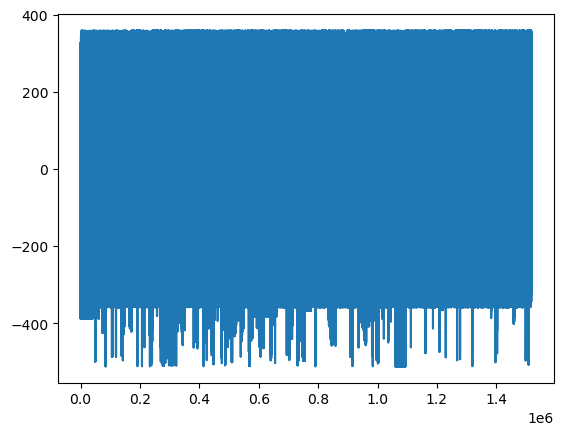

In [5]:
cleandata["drift"].plot()

In [ ]:
start = time.time()
trainingdata4 = cleandata.copy()
goaldata4 = cleandata.copy()
goaldata4 = goaldata4[["latitude","longitude"]]
trainingdata4 = trainingdata4.drop(columns=["longitude","latitude","etaRaw","portId","time_at_sea","tot_dist","time_s_l","dist_s_l","at_port","speed","drift"])
trainingdata4['time'] = pd.to_datetime(trainingdata4['time'])
trainingdata4 = trainingdata4.reindex(sorted(trainingdata4.columns), axis=1)
trainingdata4 = preprocess(trainingdata4)
print(time.time()-start)
trainingdata4.head()

In [40]:
start = time.time()
model2 = LinearRegression()
model2.fit(trainingdata4,goaldata4)
print(time.time()-start)

89.53753757476807


In [24]:
testc4 = test.copy()
slicecat = cleandata.copy()
slicecat = slicecat.drop(columns=["longitude","latitude","etaRaw","portId","time_at_sea"])
slicecat = slicecat[1234:1234+51739]
slicecat = slicecat.reset_index(drop = True)
slicecat['vesselId']=testc4['vesselId']
slicecat['time']=pd.to_datetime(testc4['time'])
slicecat = preprocess(slicecat)
for column in trainingdata4:
    if column not in slicecat:
        slicecat[column] = False
slicecat = slicecat.reindex(sorted(slicecat.columns), axis=1)
slicecat.head()

,at_port,cog,dist_s_l,drift,heading,navstat,rot,sog,speed,time,...,vesselId_clh682fbq000qghxd3vn5xo01,vesselId_clh682fbq000rghxd2u75zdbn,vesselId_clh6aqawa0000gh0z7nc8e6nd,vesselId_clh6aqawa0001gh0zmijpuho1,vesselId_clh6aqawa0002gh0zypfa5dut,vesselId_clh6aqawa0003gh0zu0aznvt2,vesselId_clh6aqawa0004gh0z12aogec9,vesselId_clh6aqawa0005gh0z64y4xyip,vesselId_clh6aqawa0006gh0zje911dl3,vesselId_clh6aqawa0007gh0z9h6zi9bo
0,False,202.5,0.000666,106.5,96,5,0,0.0,0.001900,184323.0,...,False,False,False,False,False,False,False,False,False,False
1,False,243.4,0.024298,31.4,212,1,0,0.3,0.060744,184326.0,...,False,False,False,False,False,False,False,False,False,False
2,False,139.7,0.179462,139.7,0,1,0,0.5,0.535263,184330.0,...,False,False,False,False,False,False,False,False,False,False
3,False,351.6,10.013753,-1.4,353,0,0,14.7,27.064198,184330.0,...,False,False,False,False,False,False,False,False,False,False
4,False,269.0,8.513364,0.0,269,0,0,13.8,25.972976,184332.0,...,False,False,False,False,False,False,False,False,False,False


In [44]:
start= time.time()
uniquevessel = [i for i in test.copy()['vesselId'].unique()]
uniquevessel.sort()
enesstyle = cleandata.copy()
enesstyle = enesstyle.drop(columns=["longitude","latitude","etaRaw","portId","time_at_sea","tot_dist","time_s_l","dist_s_l","at_port","speed","drift"])
enesstyle = enesstyle.sort_values(by = ['vesselId','time'])
enestest = test.copy()
enestest = enestest.sort_values(by = ['vesselId','time'])
enesstyle = enesstyle.reset_index(drop = True)
enesres = enesstyle[0:1]
for i in uniquevessel:
    boat = enestest[enestest['vesselId'] == i].reset_index(drop=True)
    bigboat = enesstyle[enesstyle['vesselId'] == i].reset_index(drop=True)
    k=0
    for _,j in boat.iterrows():
        enesres.loc[len(enesres.index)] = bigboat.iloc[min(k,len(bigboat.index)-1)]
        k+=1

enesres = enesres[1:]
print(time.time()-start)
enestest.tail()

176.28659868240356


,ID,vesselId,time,scaling_factor
51161,51161,clh6aqawa0007gh0z9h6zi9bo,2024-05-12 22:37:33,0.1
51302,51302,clh6aqawa0007gh0z9h6zi9bo,2024-05-12 22:58:05,0.1
51444,51444,clh6aqawa0007gh0z9h6zi9bo,2024-05-12 23:18:20,0.1
51595,51595,clh6aqawa0007gh0z9h6zi9bo,2024-05-12 23:39:21,0.1
51654,51654,clh6aqawa0007gh0z9h6zi9bo,2024-05-12 23:59:03,0.1


In [47]:
start = time.time()
enesresc = enesres.copy()
enesresc = enesresc.reset_index(drop = True)
enesresc['time'] = enestest.reset_index(drop=True)['time']
blblbl = test.copy()
blblbl['indexer'] = blblbl.index
blblbl=blblbl.sort_values(by=['vesselId',"time"]).reset_index(drop=True)
enesresc['indexer']= blblbl['indexer']
enesresc = enesresc.sort_values(by = ['time'])

enesresc.tail()

,time,cog,sog,rot,heading,navstat,vesselId,indexer
3235,2024-05-12 23:59:58,231.2,18.4,0,230,0,61e9f3a8b937134a3c4bfdf3,51734
12334,2024-05-12 23:59:58,324.6,16.6,-4,323,0,61e9f3d3b937134a3c4bff1b,51732
5044,2024-05-12 23:59:58,118.5,0.0,-4,4,5,61e9f3adb937134a3c4bfe39,51738
37441,2024-05-12 23:59:58,208.2,0.0,-5,75,5,61e9f465b937134a3c4c0269,51737
19730,2024-05-12 23:59:58,197.7,13.5,0,196,0,61e9f413b937134a3c4c0057,51733


In [5]:
uniquevessel = [i for i in test.copy()['vesselId'].unique()]
traincopy = train.copy()
bettertraining = traincopy[0:1]
for i in uniquevessel:
    boat = traincopy[traincopy['vesselId'] == i]
    bettertraining.loc[len(bettertraining.index)] = boat.iloc[-2]
    bettertraining.loc[len(bettertraining.index)] = boat.iloc[-1]
bettertraining.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-05-07 23:27:20,114.0,0.0,0,344,5,05-06 10:45,31.14648,-81.49789,61e9f3aeb937134a3c4bfe3d,61d38499b7b7526e1adf3d54
2,2024-05-07 23:48:16,179.6,0.0,0,344,5,05-06 10:45,31.14647,-81.49789,61e9f3aeb937134a3c4bfe3d,61d38499b7b7526e1adf3d54
3,2024-05-07 23:27:54,24.7,0.0,0,214,5,05-01 23:00,14.81694,120.29624,61e9f473b937134a3c4c02df,61d37d5799db2ccf7339ef3b
4,2024-05-07 23:57:16,24.7,0.0,0,214,5,05-01 23:00,14.81694,120.29625,61e9f473b937134a3c4c02df,61d37d5799db2ccf7339ef3b


In [6]:
traincopy = train.copy()
trainingcopy = trainingdata.copy()
testcopy = test.copy()
res = []
test2copy = test2.copy()
test2copy['sog']=0
test2copy = test2copy.reindex(sorted(test2copy.columns), axis=1)
bettertraining2 = bettertraining.copy()

k = 0
res= []

start = time.time()
for _,i in testcopy.iterrows():
    boat = bettertraining2[bettertraining2['vesselId'] == i[1]]
    min2 = boat.iloc[-2]
    min1 = boat.iloc[-1]
    sped = speed(distance.distance((min2['latitude'],min2['longitude']),(min1['latitude'],min1['latitude'])),min2['time'].timestamp(),min1['time'].timestamp())
    sped = float(str(np.abs(sped))[:-3] + "0")
    test2copy.at[k,'sog']= sped
    usghiiuhgi = pd.DataFrame(test2copy.iloc[k]).T.astype(float)
    res1 = model2.predict(usghiiuhgi)
    res.append(res1)
    blbl = [pd.to_datetime(test2copy.at[k,'time']),0,0,0,0,0,0,(float(res1[0][1])+90)%180-90,(float(res1[0][0])+90)%180-90,testcopy.at[k,'vesselId'],0]
    bettertraining2.loc[len(bettertraining2.index)] = blbl
    k+=1

In [46]:
ramg = [i for i in range(51739)]
res2 = [ramg,[(i[1]+90)%180-90 for i in res],[(i[0]+90)%180-90 for i in res]]
with open('res.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(["ID","longitude_predicted","latitude_predicted"])
    write.writerows(zip(*res2))
df = pd.read_csv('res.csv')
df.to_csv('res.csv', index=False)

In [43]:
enesresc.head()

,cog,heading,navstat,rot,sog,time,vesselId_61e9f38eb937134a3c4bfd8d,vesselId_61e9f38eb937134a3c4bfd8f,vesselId_61e9f38eb937134a3c4bfd91,vesselId_61e9f390b937134a3c4bfd93,...,vesselId_clh682fbq000qghxd3vn5xo01,vesselId_clh682fbq000rghxd2u75zdbn,vesselId_clh6aqawa0000gh0z7nc8e6nd,vesselId_clh6aqawa0001gh0zmijpuho1,vesselId_clh6aqawa0002gh0zypfa5dut,vesselId_clh6aqawa0003gh0zu0aznvt2,vesselId_clh6aqawa0004gh0z12aogec9,vesselId_clh6aqawa0005gh0z64y4xyip,vesselId_clh6aqawa0006gh0zje911dl3,vesselId_clh6aqawa0007gh0z9h6zi9bo
5045,64.0,9,1,6,0.0,11059396.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
44194,113.6,144,5,0,0.0,11059577.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
41210,40.0,39,0,0,11.7,11059802.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32880,265.0,122,1,0,0.1,11059834.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,348.0,333,5,0,0.0,11059947.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
